In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [3]:
ROOT_DIR = "brain_tumor_mri_dataset"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items() 

dict_items([('tumor', 2300), ('notumor', 2000)])

lets split data as 70% training, 15% validation and 15% test

In [4]:
#Creating training folder
if not os.path.exists("./train"):
    os.mkdir("./train")

    for dir in os.listdir(ROOT_DIR):
        os.makedirs("./train/"+dir)
        
        for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)), size =(math.floor(70/100*number_of_images[dir])-5), replace = False):
            O = os.path.join(ROOT_DIR, dir, img) #path
            D = os.path.join("./train", dir)
            shutil.copy(O,D)
            os.remove(O)

else:
    print("Train folder exist")


In [5]:
def dataFolder(p, split):
    #Creating training folder
    if not os.path.exists("./"+p):
        os.mkdir("./"+p)

        for dir in os.listdir(ROOT_DIR):
            os.makedirs("./"+p+"/"+dir)
        
            for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)), size =(math.floor(split*number_of_images[dir])-5), replace = False):
                O = os.path.join(ROOT_DIR, dir, img) #path
                D = os.path.join("./"+p, dir)
                shutil.copy(O,D)
                os.remove(O)

    else:
        print(f"{p}folder exist")


In [6]:
dataFolder("train", 0.7)

trainfolder exist


In [7]:
dataFolder("val", 0.15)

In [8]:
dataFolder("test", 0.15)

In [9]:
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items() 

dict_items([('tumor', 15), ('notumor', 15)])

# Preparing our data using Data Generator

In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
def preprocessingImages1(path):
    """
    input : Path
    output : Pre processed images
    """
    image_data = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, preprocessing_function = preprocess_input, horizontal_flip= True)
    image = image_data .flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')

    return image

In [58]:
path = "train"
train_data = preprocessingImages1(path)

Found 3000 images belonging to 2 classes.


In [59]:
train_data.class_indices

{'notumor': 0, 'tumor': 1}

In [60]:
def preprocessingImages2(path):
    """
    input : Path
    output : Pre processed images
    """
    image_data = ImageDataGenerator(preprocessing_function = preprocess_input)
    image = image_data .flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')

    return image

In [61]:
path = "test"
test_data = preprocessingImages2(path)

Found 635 images belonging to 2 classes.


In [62]:
path = "val"
val_data = preprocessingImages2(path)

Found 635 images belonging to 2 classes.


# Model Training

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.mobilenet import MobileNet
import keras

In [64]:
base_model = MobileNet(input_shape = (224,224,3), include_top = False)

17225924/17225924 [==============================] - 1s 0us/step


In [65]:
for layer in base_model.layers:
    layer.trainable = False 

In [67]:
X = Flatten()(base_model.output)
X = Dense(units = 1, activation = "sigmoid")(X)

model = Model(base_model.input, X)

In [69]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [71]:
model.compile(optimizer="rmsprop", loss= keras.losses.binary_crossentropy, metrics = ["accuracy"])

In [73]:
# Call Back
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint(filepath= "bestmodel.h5", monitor = "val_accuracy", verbose = 1, save_best_only = True)
# Early Stopping
es= EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience=3, verbose= 1)
cb = [mc, es]

In [74]:
hist = model.fit_generator(train_data,
                           steps_per_epoch = 8,
                           epochs = 30,
                           validation_data = val_data,
                           validation_steps = 16,
                           callbacks=cb )

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 2.5282 - accuracy: 0.8047 
Epoch 1: val_accuracy improved from -inf to 0.93359, saving model to bestmodel.h5
8/8 [==============================] - 17s 2s/step - loss: 2.5282 - accuracy: 0.8047 - val_loss: 0.6598 - val_accuracy: 0.9336
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.9682 - accuracy: 0.9062
Epoch 2: val_accuracy improved from 0.93359 to 0.95898, saving model to bestmodel.h5
8/8 [==============================] - 15s 2s/step - loss: 0.9682 - accuracy: 0.9062 - val_loss: 0.3042 - val_accuracy: 0.9590
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.6145 - accuracy: 0.9023
Epoch 3: val_accuracy did not improve from 0.95898
8/8 [==============================] - 15s 2s/step - loss: 0.6145 - accuracy: 0.9023 - val_loss: 0.4275 - val_accuracy: 0.9453
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.3399 - accuracy: 0.9375
Epoch 4: val_accuracy did not im

In [76]:
# load the best fit model 
model = load_model("bestmodel.h5")

In [85]:
acc = model.evaluate_generator(test_data)[1]
print(f"The model accuracy is {acc*100}%")

The model accuracy is 97.32283353805542%


In [78]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

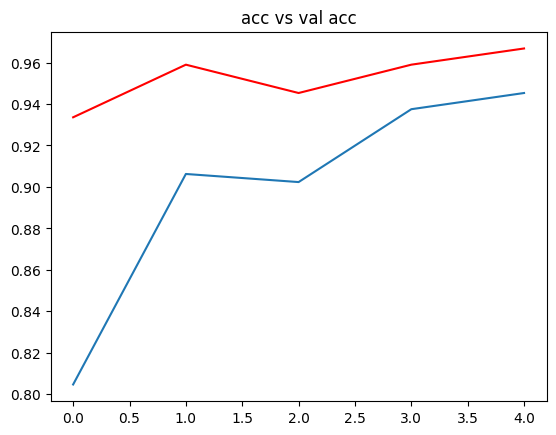

In [79]:
plt.plot(h["accuracy"])
plt.plot(h["val_accuracy"], c = "red")
plt.title("acc vs val acc")
plt.show()

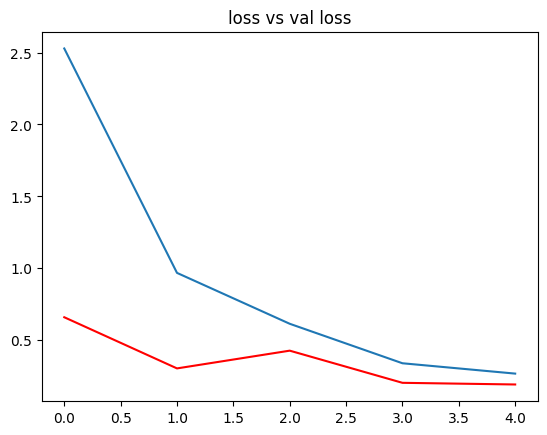

In [80]:
plt.plot(h["loss"])
plt.plot(h["val_loss"], c = "red")
plt.title("loss vs val loss")
plt.show()

In [36]:
train_data.class_indices

{'notumor': 0, 'tumor': 1}

1/1 [==============================] - 0s 49ms/step
Predicted probability: 0.0000
The MRI image is not having a Brain Tumor


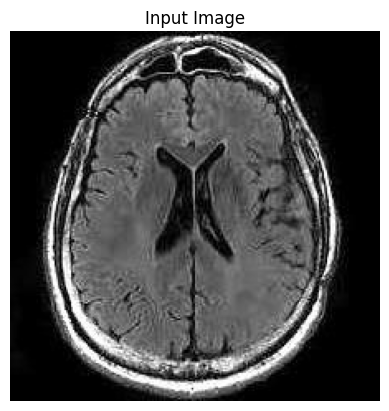

In [112]:

from tensorflow.keras.preprocessing import image 

path = "brain_tumor_mri_dataset/notumor/no-1301.jpg"
img = load_img(path, target_size = (224, 224))
i = image.img_to_array(img) / 255.0

input_arr = np.expand_dims(i, axis=0) 

pred = model.predict(input_arr)[0][0]
print(f"Predicted probability: {pred:.4f}")

if pred >= 0.5:
    print("The MRI image is of a Brain Tumor")
else:
    print("The MRI image is not having a Brain Tumor")

plt.imshow(i)
plt.title("Input Image")
plt.axis('off')
plt.show()
